# Detecção e Classificação de Frentes Meteorologicas - FD_FC (Front Dection & Front Classification)

* O melhor modelo esta guardado em model_weights/cnn_ad_model_.pth </br>
* O script the treinamento é o fd_Fc_CNN_123.py
* Na pasta samples, contém os dados que foram usados para a inferência

Este NoteBook é um Notebook para a inferência. E explica superficialmente sobre o pre-processamento dos dados. 



**Author:** Edson Cláudio Tchivango Segunda

## FD_FC - Inference

In [2]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from datetime import datetime, timedelta
from tqdm import tqdm
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import random
import cv2
print("Running with torch version:", torch.__version__)

Running with torch version: 2.7.1+cu126


## Data Processing

In [3]:
from skimage.transform import resize

image_dir = "fd_fc_test2021-03_tiff"  # <-- Atualize esse caminho com o seu

# === Função para processar uma máscara RGB ===
def preprocess_mask(path):
    image = Image.open(path).convert("RGB")
    image = image.resize((320, 320), resample=Image.NEAREST)
    img_np = np.array(image) #/ 255 #I gotta pain attention to this...

    """
    mask = np.zeros((320, 320), dtype=np.uint8)
    BLUE = (0, 0, 238)
    RED = (255, 0, 0)
    PURPLE = (145, 44, 238)

    mask[np.all(img_np == BLUE, axis=-1)] = 1
    mask[np.all(img_np == RED, axis=-1)] = 2
    mask[np.all(img_np == PURPLE, axis=-1)] = 3
    
    """
    class_map = np.zeros((img_np.shape[0], img_np.shape[1]), dtype=np.uint8)

    # Define os intervalos de cor para cada tipo de frente
    BLUE_MIN   = np.array([0, 0, 10])
    BLUE_MAX   = np.array([10, 10, 255])

    RED_MIN    = np.array([10, 0, 0])
    RED_MAX    = np.array([255, 10, 10])

    PURPLE_MIN = np.array([35, 35, 225])
    PURPLE_MAX = np.array([156, 49, 256])

    # Máscaras booleanas por cor
    is_blue   = np.all((img_np >= BLUE_MIN) & (img_np <= BLUE_MAX), axis=-1)
    is_red    = np.all((img_np >= RED_MIN) & (img_np <= RED_MAX), axis=-1)
    is_purple = np.all((img_np >= PURPLE_MIN) & (img_np <= PURPLE_MAX), axis=-1)

    class_map[is_blue] = 1    # Frente fria
    class_map[is_red] = 2     # Frente quente
    class_map[is_purple] = 3  # Frente ocluída 

    kernel = np.ones((15, 15), np.uint8)
    mask_dilated = cv2.dilate(class_map, kernel, iterations=1)
    return mask_dilated

# === Carregar todas as máscaras ===
def load_all_masks():
    paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")])
    return np.stack([preprocess_mask(p) for p in paths])

# === Função para interpolar e normalizar variáveis do ERA5 ===
def process_variable(var):
    normed = []
    for i in range(var.shape[0]):
        data = var[i].values
        data_resized = resize(data, (320, 320), order=1, mode='edge', anti_aliasing=False)
        data_norm = (data_resized - np.min(data_resized)) / (np.max(data_resized) - np.min(data_resized) + 1e-6)
        normed.append(data_norm)
    return np.stack(normed)

# === Função principal para carregar dados ===

def load_data(netcdf_path):
    ds = xr.open_dataset(netcdf_path)

    msl = process_variable(ds['msl'])
    t2m = process_variable(ds['t2m'])
    d2m = process_variable(ds['d2m'])
    u10 = process_variable(ds['u10'])
    v10 = process_variable(ds['v10'])
    wind_mag = np.sqrt(u10**2 + v10**2)

    X = np.stack([msl, t2m, wind_mag, d2m], axis=1)  # Shape: (Sample, channel, 320=W, 320=H)
    Y = load_all_masks()  # Shape: (Sample, 320=W, 320=H)
    return X, Y

## Data Loading

In [4]:

ncfile_2021 = "fd_fc_test2021-0315.nc" # Reading the netcd file as the input data

# loading the Era5 variables and the images for later compare with the predicted values
X, masks = load_data(ncfile_2021)

print(X.shape, type(X)) # Printing the shape of the X or Era5 data
print(masks.shape, type(masks))  # Printing the shape of the Y or the masks


(60, 4, 320, 320) <class 'numpy.ndarray'>
(60, 320, 320) <class 'numpy.ndarray'>


In [5]:
# Preview of Era5 Data Structure
ncfile_2021_03 = xr.open_dataset(ncfile_2021)
ncfile_2021_03

<xarray.Dataset> Size: 124MB
Dimensions:     (valid_time: 60, latitude: 321, longitude: 321)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 480B 2021-03-01 ... 2021-03-15T18...
  * latitude    (latitude) float64 3kB 15.0 14.75 14.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 3kB -100.0 -99.75 -99.5 ... -20.25 -20.0
    expver      (valid_time) <U4 960B ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 25MB ...
    v10         (valid_time, latitude, longitude) float32 25MB ...
    d2m         (valid_time, latitude, longitude) float32 25MB ...
    t2m         (valid_time, latitude, longitude) float32 25MB ...
    msl         (valid_time, latitude, longitude) float32 25MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-28T18:12 GRIB to CDM+CF via cfgrib-0.9.1...

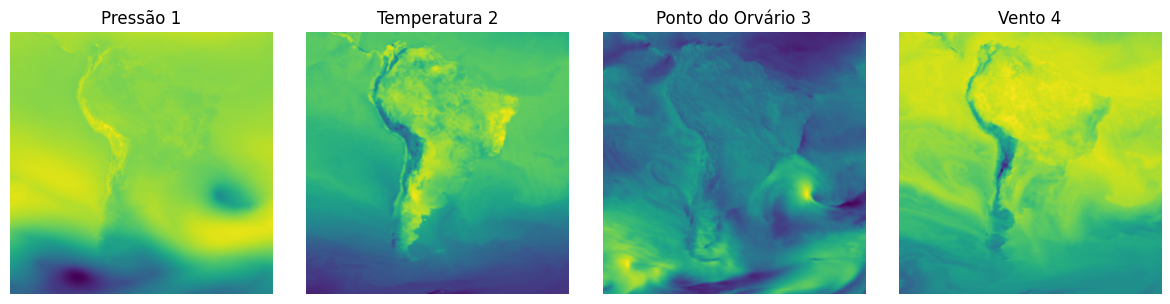

In [6]:
# Ploting or Preview of the data

fig, axes = plt.subplots(1, 4, figsize=(12, 3)) # Figsize

# Iterate through the 4 variables (indices 0 to 3) in X[123] and plot in the corresponding subplot
for v in range(4):
    ax = axes[v] # Select the specific subplot axis
    ax.imshow(X[23][v]) # Plot the v variable
    if(v == 0):
        ax.set_title(f'Pressão {v+1}') # Set a title
    elif(v == 1):
        ax.set_title(f'Temperatura {v+1}') # Set a title 
    elif(v == 2):
        ax.set_title(f'Ponto do Orvário {v+1}') # Set a title
    elif(v == 3):
        ax.set_title(f'Vento {v+1}') # Set a title
    ax.axis('off') 

# Adjusting layout to prevent titles/labels from overlapping
plt.tight_layout()

# Display the figure with all four plots
plt.show()

## Mask Plotting 
This plots shows the process of getting the mask until the point of dilation. The mask that was inserted to the neural network, was converted to class as shown in the script above (Data Processing) where 1= Blue, 2 = Red and 3 = Purple

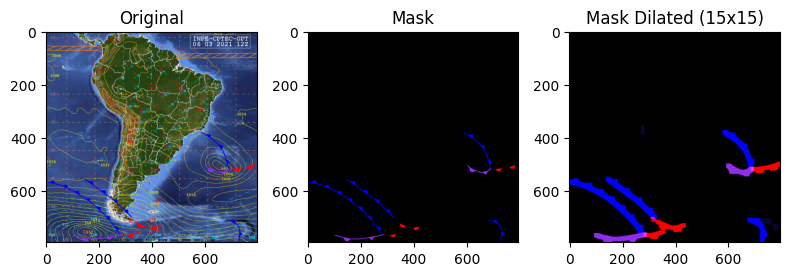

In [7]:
import matplotlib.image as mpimg

raw =  mpimg.imread("fd_fc_test2021-03_tiff_raw/superficie_2021030612.gif.png")
mask_ =  mpimg.imread("fd_fc_test2021-03_tiff/superficie_2021030612.gif.png")


## Dilation 
kernel = np.ones((15, 15), np.uint8)
mask_di = cv2.dilate(mask_, kernel, iterations=1)

fig, axes = plt.subplots(1, 3, figsize=(8, 4)) # Figsize

axes[0].imshow(raw)
axes[0].set_title("Original")

axes[1].imshow(mask_)
axes[1].set_title("Mask")

axes[2].imshow(mask_di)
axes[2].set_title("Mask Dilated (15x15)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
#plt.savefig("Raw_and_Mask.png")
plt.show() 

## Model RGB Classification

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# ==== Dataset Personalizado ====
class FrontDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# ==== CNN Profissional ====
class AdvancedCNN(nn.Module):
    def __init__(self, in_channels=4, num_classes=4):
        super(AdvancedCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Loading Model and make Prediction

### Classification Model - Classes (background=0, Cold=1, Warm=2, Occluded=3)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = AdvancedCNN_RGB().to(device)
model = AdvancedCNN().to(device)
model.load_state_dict(torch.load("fd_fc/fd_fc_CNNad_123/fd_fc_CNNad_123/cnn_ad_model_.pth", map_location=device)) # Loading model
model.eval()

# Predicting 
test_data_array = X.astype(np.float32)
with torch.no_grad():
    Xb = torch.from_numpy(test_data_array).to(device)
    logits = model(Xb)              # (B,4,H,W)
    probs  = torch.softmax(logits, dim=1)      # 0..1, sum=1 per pixel
    pred   = logits.argmax(dim=1)              # class map (B,H,W)

print(f"Shape of probs:{probs.shape}")
print(f"Shape of pred:{pred.shape}")


Shape of probs:torch.Size([60, 4, 320, 320])
Shape of pred:torch.Size([60, 320, 320])


### Class Plotting Before RGB Conversion
The plots are the same, but one is showing one class and the other one is showing all classes, this is just to see the raw output of the model

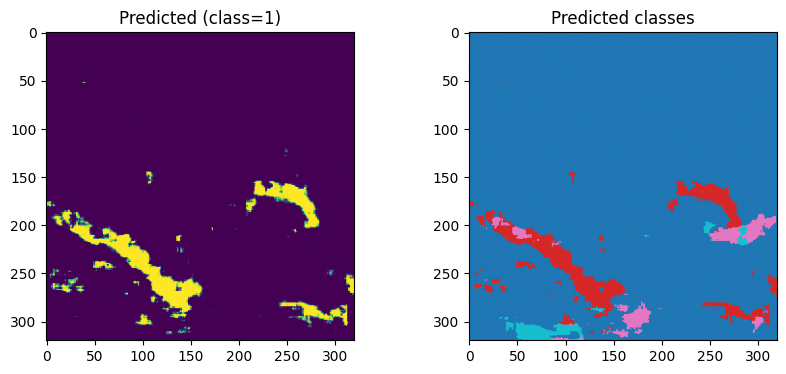

In [10]:
# visualize probabilities for each class (example: class 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Predicted (class=1)")
#plt.colorbar()
plt.imshow(probs[22, 1].cpu(), vmin=0, vmax=1)
plt.subplot(1, 2, 2)
plt.title("Predicted classes")
plt.imshow(pred[22].cpu(), cmap="tab10");
plt.show()

### Converting Classes to RGB

In [11]:
import numpy as np

# Ranges
BLUE_MIN   = np.array([0, 0, 10],   dtype=np.int16)
BLUE_MAX   = np.array([10, 10, 255],dtype=np.int16)

RED_MIN    = np.array([10, 0, 0],   dtype=np.int16)
RED_MAX    = np.array([255, 10, 10],dtype=np.int16)

PURPLE_MIN = np.array([35, 35, 225],dtype=np.int16)
PURPLE_MAX = np.array([156, 49, 256],dtype=np.int16)  # 256 will be clipped to 255

def _midpoint(minv, maxv):
    # Safe midpoint in int
    return np.clip(((minv + maxv) // 2), 0, 255).astype(np.uint8)

def _random_in_range(minv, maxv, size):
    # Random inclusive lower-bound, exclusive upper-bound; clip to 255
    low  = np.maximum(minv, 0)
    high = np.minimum(maxv, 256)  # allow 256 as exclusive upper bound
    # Broadcast to (H, W, 3) via per-channel sampling
    out = np.zeros((size[0], size[1], 3), dtype=np.uint8)
    for c in range(3):
        out[..., c] = np.random.randint(low[c], high[c], size=size, dtype=np.uint16).clip(0, 255).astype(np.uint8)
    return out

def classes_to_rgb_from_ranges(pred, strategy="midpoint", seed=None):
    """
    pred: (H, W) integer classes: 0=background, 1=blue, 2=red, 3=purple
    strategy: "midpoint" or "random"
    seed: int or None (for reproducibility in random mode)
    returns: (H, W, 3) uint8
    """
    if seed is not None and strategy == "random":
        np.random.seed(seed)

    H, W = pred.shape
    rgb = np.zeros((H, W, 3), dtype=np.uint8)  # background = black [0,0,0]

    # Build per-class color map
    if strategy == "midpoint":
        c1 = _midpoint(BLUE_MIN,   BLUE_MAX)   # class 1
        c2 = _midpoint(RED_MIN,    RED_MAX)    # class 2
        c3 = _midpoint(PURPLE_MIN, PURPLE_MAX) # class 3

        rgb[pred == 1] = c1
        rgb[pred == 2] = c2
        rgb[pred == 3] = c3

    elif strategy == "random":
        # Masks for each class
        m1 = (pred == 1)
        m2 = (pred == 2)
        m3 = (pred == 3)

        if m1.any():
            rgb[m1] = _random_in_range(BLUE_MIN,   BLUE_MAX,   (m1.sum(), 1)).reshape(-1,3)
        if m2.any():
            rgb[m2] = _random_in_range(RED_MIN,    RED_MAX,    (m2.sum(), 1)).reshape(-1,3)
        if m3.any():
            rgb[m3] = _random_in_range(PURPLE_MIN, PURPLE_MAX, (m3.sum(), 1)).reshape(-1,3)

        # Reshape above uses 1-width trick; alternatively fill per-channel using boolean masks
    else:
        raise ValueError("strategy must be 'midpoint' or 'random'")

    return rgb


### Plotting the Prediction vs GroundTruth

Saved output_plots/plot_index_000.png
Saved output_plots/plot_index_001.png
Saved output_plots/plot_index_002.png
Saved output_plots/plot_index_003.png
Saved output_plots/plot_index_004.png
Saved output_plots/plot_index_005.png
Saved output_plots/plot_index_006.png
Saved output_plots/plot_index_007.png
Saved output_plots/plot_index_008.png
Saved output_plots/plot_index_009.png
Saved output_plots/plot_index_010.png
Saved output_plots/plot_index_011.png
Saved output_plots/plot_index_012.png
Saved output_plots/plot_index_013.png
Saved output_plots/plot_index_014.png
Saved output_plots/plot_index_015.png
Saved output_plots/plot_index_016.png
Saved output_plots/plot_index_017.png
Saved output_plots/plot_index_018.png
Saved output_plots/plot_index_019.png
Saved output_plots/plot_index_020.png
Saved output_plots/plot_index_021.png
Saved output_plots/plot_index_022.png
Saved output_plots/plot_index_023.png
Saved output_plots/plot_index_024.png
Saved output_plots/plot_index_025.png
Saved output

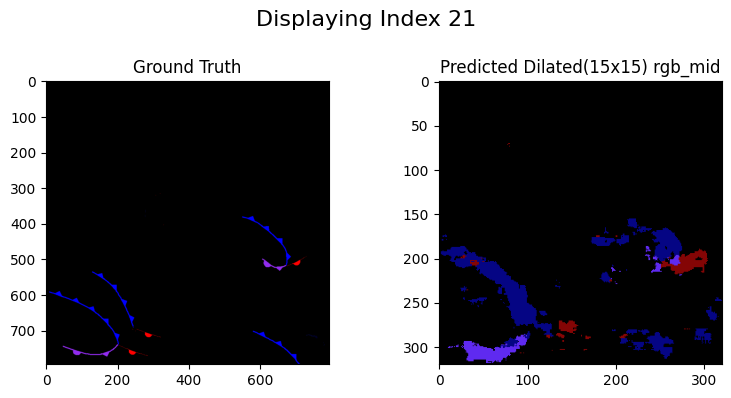

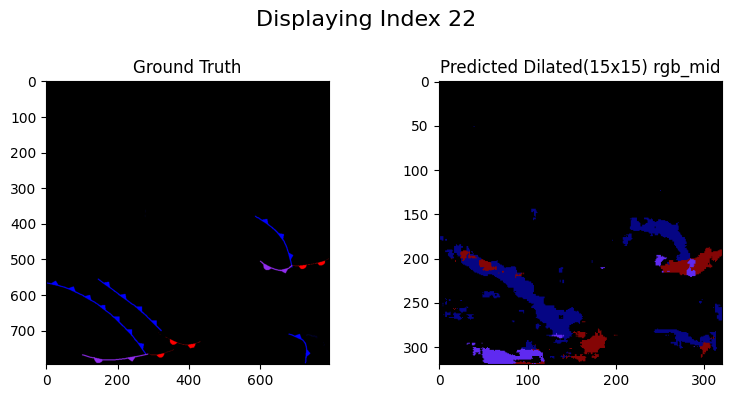

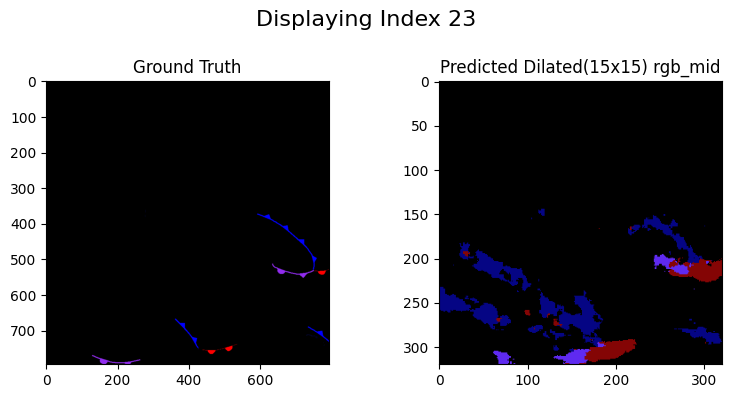

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Ensure the output directory for saved images exists
save_dir = "output_plots"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def load_all_masks_without_preprocessing(image_dir):
    paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".png")])
    images_list = [np.array(Image.open(p)) for p in paths]
    return np.stack(images_list)

# --- Assume these functions/variables are defined elsewhere ---
# def classes_to_rgb_from_ranges(...): ...
# pred = ... 
# rgb_mid = classes_to_rgb_from_ranges(pred[22], strategy="midpoint")
# rgb_rand = classes_to_rgb_from_ranges(pred[22], strategy="random", seed=42)
# -----------------------------------------------------------

raw_mask = load_all_masks_without_preprocessing("fd_fc_test2021-03_tiff")

#print(f"Shape of raw_mask data: {raw_mask.shape}")
#print(f"Shape of rgb_mid data: {rgb_mid.shape}")


# 1. Loop through indices 0 to 59 and save the plots

for i in range(60): # Range 0 to 59 (inclusive)
    # Re-calculate rgb_mid and rgb_rand for each index 'i' if 'pred' holds all predictions
    current_rgb_mid = classes_to_rgb_from_ranges(pred[i], strategy="midpoint") 
    current_rgb_rand = classes_to_rgb_from_ranges(pred[i], strategy="random", seed=42) # This kind of veiw, was commmented
    current_mask = raw_mask[i]
    
    # Create the figure for the current index
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(current_mask)
    axes[0].set_title(f"Ground Truth (Index {i})")
    axes[1].imshow(current_rgb_mid)
    axes[1].set_title("Predicted Dilated(15x15) rgb_mid")
    #axes[2].imshow(current_rgb_rand)
    #axes[2].set_title("rgb_rand")
    
    plt.tight_layout()
    
    # Save the figure with a descriptive filename
    save_path = os.path.join(save_dir, f"plot_index_{i:03d}.png")
    plt.savefig(save_path)
    plt.close(fig) # Close the figure to free up memory
    print(f"Saved {save_path}")


# 2. Plot and show only indices 21, 22, and 23

print("\nDisplaying plots for indices 21 to 23...")

for i in range(21, 24): # Range 21, 22, 23 (inclusive)
    # Re-calculate rgb values for the specific index
    current_rgb_mid = classes_to_rgb_from_ranges(pred[i], strategy="midpoint")
    current_rgb_rand = classes_to_rgb_from_ranges(pred[i], strategy="random", seed=42)
    current_mask = raw_mask[i]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(f"Displaying Index {i}", fontsize=16)

    axes[0].imshow(current_mask)
    axes[0].set_title("Ground Truth")
    
    axes[1].imshow(current_rgb_mid)
    axes[1].set_title("Predicted Dilated(15x15) rgb_mid")
    
    #axes[2].imshow(current_rgb_rand)
    #axes[2].set_title("rgb_rand")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.show() # Display the plot interactively


# Metrics Analysis 

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def evaluate_per_class(model, val_loader, device, class_names=None):
    """
    Works with targets either as:
      - class indices: (B, H, W), dtype long/int
      - one-hot:       (B, C, H, W), dtype float/bool
    Model must output logits: (B, C, H, W).
    """
    model.eval()
    n_classes = None
    conf = None
    with torch.no_grad():
        for Xb, Yb in val_loader:
            Xb = Xb.to(device)

            # ----- get true labels (B,H,W) -----
            if Yb.dim() == 4 and Yb.size(1) > 1:        # one-hot
                true = Yb.argmax(dim=1).long()
            elif Yb.dim() == 3:                          # class indices
                true = Yb.long()
            else:
                raise ValueError(f"Unexpected Y shape {tuple(Yb.shape)}")

            true = true.to(device)

            # ----- forward -----
            logits = model(Xb)                            # (B,C,H,W)
            if n_classes is None:
                n_classes = logits.shape[1]
                conf = torch.zeros((n_classes, n_classes), dtype=torch.long, device='cpu')

            pred = logits.argmax(dim=1)                  # (B,H,W)

            # ----- accumulate confusion matrix -----
            t = true.view(-1).cpu()
            p = pred.view(-1).cpu()
            idx = t * n_classes + p
            cm = torch.bincount(idx, minlength=n_classes*n_classes).reshape(n_classes, n_classes)
            conf += cm

    conf = conf.numpy()
    eps = 1e-9
    tp = np.diag(conf).astype(np.float64)
    fn = conf.sum(axis=1) - tp
    fp = conf.sum(axis=0) - tp

    support = conf.sum(axis=1)          # GT pixels per class
    predcnt = conf.sum(axis=0)          # predicted pixels per class

    acc_cls  = tp / (support + eps)     # recall per class
    prec     = tp / (tp + fp + eps)
    rec      = tp / (tp + fn + eps)
    f1       = 2*prec*rec / (prec + rec + eps)
    iou      = tp / (tp + fp + fn + eps)
    miou     = iou.mean()

    support_pct = 100 * support / (support.sum() + eps)
    pred_pct    = 100 * predcnt / (predcnt.sum() + eps)

    if class_names is None:
        class_names = [f"class_{i}" for i in range(n_classes)]

    print("\nPer-class metrics:")
    print(f"{'Class':<12}{'Support%':>10}{'Pred%':>10}{'Acc/Recall':>12}{'Precision':>12}{'F1':>10}{'IoU':>10}")
    for i, name in enumerate(class_names):
        print(f"{name:<12}{support_pct[i]:10.2f}{pred_pct[i]:10.2f}{acc_cls[i]:12.3f}{prec[i]:12.3f}{f1[i]:10.3f}{iou[i]:10.3f}")
    print(f"\nMean IoU (mIoU): {miou:.3f}")

    # Quick bar plots
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.title("Ground Truth distribution (%)"); plt.bar(range(n_classes), support_pct); plt.xticks(range(n_classes), class_names, rotation=45, ha='right')
    plt.subplot(1,2,2); plt.title("Predicted distribution (%)"); plt.bar(range(n_classes), pred_pct); plt.xticks(range(n_classes), class_names, rotation=45, ha='right')
    plt.tight_layout(); plt.show()

    return dict(confusion_matrix=conf, accuracy_per_class=acc_cls, precision=prec, recall=rec, f1=f1, iou=iou, miou=miou,
                support=support, pred_count=predcnt, support_pct=support_pct, pred_pct=pred_pct)



Per-class metrics:
Class         Support%     Pred%  Acc/Recall   Precision        F1       IoU
background       91.53     92.69       0.968       0.956     0.962     0.927
cold              5.85      5.16       0.472       0.535     0.502     0.335
warm              1.79      1.53       0.358       0.420     0.386     0.239
occluded          0.83      0.62       0.404       0.538     0.461     0.300

Mean IoU (mIoU): 0.450


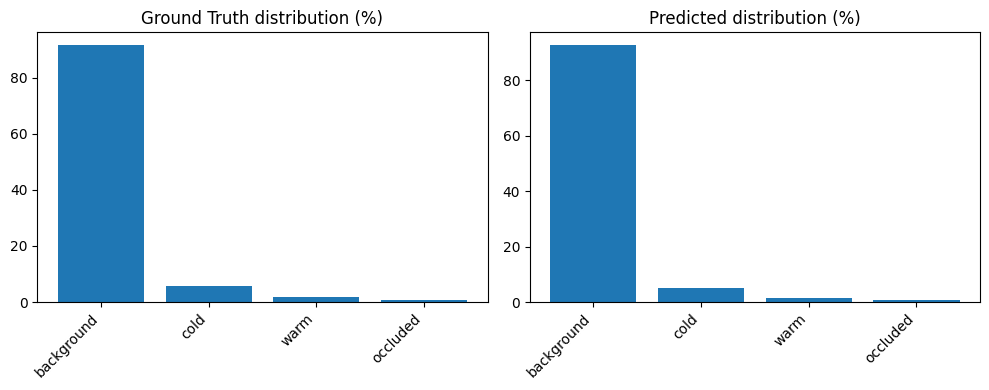

In [15]:
# class order example (0=background, 1=cold, 2=warm, 3=occluded)
# Separar treino/teste
X_train, X_val = X[:4], X[4:]
Y_train, Y_val = masks[:4], masks[4:]
X_val = X ;Y_val = masks 
train_dataset = FrontDataset(X_train, Y_train)
val_dataset = FrontDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
class_names = ["background", "cold", "warm", "occluded"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = AdvancedCNN_RGB().to(device)
model = AdvancedCNN().to(device)
model.load_state_dict(torch.load("fd_fc/fd_fc_CNNad_123/fd_fc_CNNad_123/cnn_ad_model_.pth", map_location=device))
#model.eval()

metrics = evaluate_per_class(model, val_loader, device, class_names)


## Matrix Confusion

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def compute_confusion_matrix_seg(model, loader, device, n_classes=None, ignore_index=None):
    """
    Computes confusion matrix for semantic segmentation.
    - model: outputs logits (B, C, H, W)
    - loader: yields (X, Y), where Y is class IDs (B,H,W) or one-hot (B,C,H,W)
    - ignore_index: class ID to exclude from counts (e.g., 0 for background). If None, include all.
    Returns:
      cm: (C, C) array with counts (rows=true, cols=pred)
    """
    model.eval()
    cm = None
    with torch.no_grad():
        for Xb, Yb in loader:
            Xb = Xb.to(device)

            # unify target to class IDs (B,H,W)
            if Yb.dim() == 4 and Yb.size(1) > 1:  # one-hot
                true = Yb.argmax(dim=1).long()
            elif Yb.dim() == 3:                    # class indices
                true = Yb.long()
            else:
                raise ValueError(f"Unexpected target shape {tuple(Yb.shape)}")

            true = true.to(device)
            logits = model(Xb)                      # (B,C,H,W)
            pred = logits.argmax(dim=1)            # (B,H,W)

            if n_classes is None:
                n_classes = logits.shape[1]

            t = true.view(-1)
            p = pred.view(-1)

            if ignore_index is not None:
                keep = (t != ignore_index)
                t = t[keep]
                p = p[keep]

            # bincount confusion rows=true, cols=pred
            idx = t * n_classes + p
            hist = torch.bincount(idx, minlength=n_classes*n_classes)
            hist = hist.reshape(n_classes, n_classes).cpu().numpy()

            if cm is None:
                cm = hist
            else:
                cm += hist
    return cm

def plot_confusion_matrix(cm, class_names=None, normalize=None, cmap="Blues", value_fmt="{:d}"):
    """
    Plots a confusion matrix.
    - cm: (C, C) counts, rows=true, cols=pred
    - normalize: None | 'true' (row) | 'pred' (col) | 'all'
    - class_names: list of class labels. If None, uses indices.
    - value_fmt: format for cell annotations (use '{:.2f}' when normalized)
    """
    cm = cm.astype(np.float64)

    if normalize is not None:
        if normalize == "true":        # row-normalize
            denom = cm.sum(axis=1, keepdims=True)
        elif normalize == "pred":      # col-normalize
            denom = cm.sum(axis=0, keepdims=True)
        elif normalize == "all":       # global
            denom = cm.sum()
        else:
            raise ValueError("normalize must be None, 'true', 'pred', or 'all'.")

        cm = cm / (denom + 1e-9)
        if value_fmt == "{:d}":
            value_fmt = "{:.2f}"

    C = cm.shape[0]
    if class_names is None:
        class_names = [f"class_{i}" for i in range(C)]

    plt.figure(figsize=(1.4*C, 1.2*C))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(C)
    plt.xticks(tick_marks, class_names, rotation=45, ha="right")
    plt.yticks(tick_marks, class_names)

    # Annotate cells
    thresh = cm.max() / 2.0 if cm.size else 0.5
    for i in range(C):
        for j in range(C):
            plt.text(j, i, value_fmt.format(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True class")
    plt.xlabel("Predicted class")
    plt.tight_layout()
    plt.show()


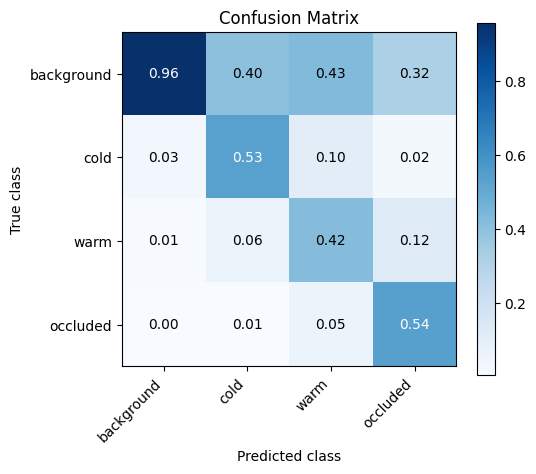

In [17]:
#  classes (0=background, 1=cold, 2=warm, 3=occluded)
class_names = ["background", "cold", "warm", "occluded"]

# Compute CM (exclude background from counts if you want foreground-only view)
cm = compute_confusion_matrix_seg(model, val_loader, device, ignore_index=None)  # or 0

# Raw counts
#plot_confusion_matrix(cm, class_names=class_names, normalize=None, value_fmt="{:d}")
#plot_confusion_matrix(cm, class_names=class_names, normalize="true", value_fmt="{:.2f}")

# Row-normalized (recall per true class)
#plot_confusion_matrix(cm, class_names=class_names, normalize="true", value_fmt="{:.2f}")

# Column-normalized (precision per predicted class)
plot_confusion_matrix(cm, class_names=class_names, normalize="pred", value_fmt="{:.2f}")

# Globally normalized (proportions)
#plot_confusion_matrix(cm, class_names=class_names, normalize="all", value_fmt="{:.2f}")


# Post-Processing

## Georeferencing The Output

### Saving image for later Georeferecing

In [18]:
# Converting image to png and saving. In this case was chosen the image at index 22 refering to 2021-03-06 06:00
rgb_mid = classes_to_rgb_from_ranges(pred[22], strategy="midpoint")

rgb_image = cv2.cvtColor(rgb_mid, cv2.COLOR_BGR2RGB)
cv2.imshow("RGB MId", rgb_image)
# Define the filename with the .png extension
filename = "rgb_mid.png"

# Save the image as a PNG file
cv2.imwrite(filename, rgb_image)

print(f"Image saved as {filename}")
cv2.waitKey(0)
cv2.destroyAllWindows()

Image saved as rgb_mid.png


## Method to Georeferencing

In [19]:
from affine import Affine
from rasterio.plot import show
import rasterio
from rasterio.control import GroundControlPoint
from rasterio.transform import from_gcps

def georeferecing(unRefRaster_, dst):
    unRefRaster = rasterio.open(unRefRaster_)
    
    gcps = [
        GroundControlPoint(row=0, col=0, x=-97, y=-62),
        #GroundControlPoint(row=184, col=765, x=-80, y=-60),
        GroundControlPoint(row=320, col=320, x=-22, y=12.5)
        # Add more GCPs as needed for accuracy
    ]
    points = gcps
    
    #get transformation array from points
    transformation = rasterio.transform.from_gcps(points)
    
    #define output raster
    #outputPath = f"masked_frontdetection/data_science/{dst}.tif"
    outputPath = f"{dst}.tif"
    #create raster and write bands
    with rasterio.open(
        outputPath,
        'w',
        driver='GTiff',
        height=unRefRaster.read(1).shape[0],
        width=unRefRaster.read(1).shape[1],
        count=3,
        dtype=unRefRaster.read(1).dtype,
        crs=rasterio.crs.CRS.from_epsg(4326),
        transform=transformation,
    ) as dst:
        #datetime_str = tiffdate_(dst.name)  # Gathering and converting datetime
        #dst.update_tags(TIFFTAG_DATETIME=datetime_str) # Assigning Datetime to tiff
        dst.write(unRefRaster.read(1), 1)
        dst.write(unRefRaster.read(2), 2)
        dst.write(unRefRaster.read(3), 3)

## Flipping the Image
The process of georeferencing flipped vertically the image.

In [20]:
from rasterio.transform import from_origin

def flipping_vertically(raster_img, dst):
      ## Flipped Vertically correction 
    
    with rasterio.open(raster_img) as src:
        transform = src.transform
        # Assuming you want to flip vertically
        new_transform = transform * from_origin(0, src.height, 1, 1)
        # Create a new dataset with the modified transform
        with rasterio.open(
            f"{dst}.tif",
            'w',
            driver=src.driver,
            width=src.width,
            height=src.height,
            count=src.count,
            dtype=src.dtypes[0],
            crs=src.crs,
            transform=new_transform,
        ) as dst:
            for i in range(1, src.count + 1):
                dst.write(src.read(i), i)

In [21]:
gref = "gref.png"
georeferecing(filename, f"{gref}")

/home/edson/miniconda3/envs/dl_pytorch/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [22]:
flipped = "flipped_"
flipping_vertically(f"{gref}.tif", flipped)

### Plotting the GeoRefereced Image

(320, 320)
left:-97.0, top:-62.0, right:-22.0, bottom:12.5


/home/edson/miniconda3/envs/dl_pytorch/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


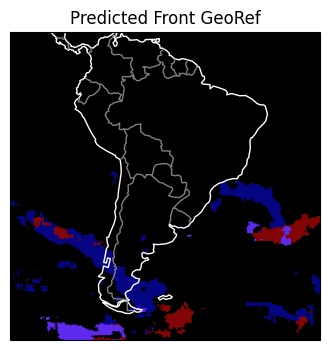

In [23]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import rasterio
import numpy as np

### Inverting Array or Rotating array
georasterp = f"{flipped}.tif"

imgsrc = rasterio.open(georasterp)

print(imgsrc.shape)
with rasterio.open(georasterp) as src:
    image_data = src.read(3)  # Read the first band
    imgallb = src.read()
    imgallb = np.array(imgallb)
    image_mn3 = imgallb.transpose((1, 2, 0))
    #rgb_image = np.stack((src.read(1), src.read(2), src.read(3)))
    transform = src.transform
    image_crs = src.crs

fig = plt.figure(figsize=(6, 4))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # Projection
ax.add_feature(cfeature.COASTLINE, color='white') # Add map features for context
ax.add_feature(cfeature.BORDERS, color='gray')#, linestyle=':')
#ax.gridlines(draw_labels=True) # Grid lines
# Set the map to be global
#ax.set_global()

# Calculate image extent in geographic coordinates
left, top, right, bottom = rasterio.transform.array_bounds(
    src.height, src.width, transform
)

print(f"left:{left}, top:{top}, right:{right}, bottom:{bottom}")
extent = (left, right, top, bottom) # [lonmin, lonmax, latmin, latmax]

ax.imshow(image_mn3, origin='upper', transform=ccrs.PlateCarree(), extent=extent, zorder=0)
# Adjust zorder if other map elements need to be on top or below
plt.title('Predicted Front GeoRef')
plt.savefig("pred_georefered.png")
plt.show()

### Geopandas Ploting Tiff images

In [24]:
import numpy as np
import rasterio
from rasterio import features
import geopandas as gpd
from shapely.geometry import shape

def tiff_to_polygons_gdf(tif_path, band=1):
    with rasterio.open(tif_path) as src:
        arr = src.read(band)             # (H, W)
        transform = src.transform
        crs = src.crs
        nodata = src.nodata

    # Build mask: include valid pixels only
    mask = np.ones_like(arr, dtype=bool)
    if nodata is not None:
        mask &= (arr != nodata)
    mask &= ~np.isnan(arr)

    geoms = []
    vals = []

    # features.shapes yields (geojson_geom, value) for uniform contiguous regions
    for geom, val in features.shapes(arr, mask=mask, transform=transform):
        # Optional: skip background (e.g., class 0)
        # if val == 0: continue
        geoms.append(shape(geom))
        vals.append(val)

    gdf = gpd.GeoDataFrame({"value": vals}, geometry=geoms, crs=crs)
    return gdf

# Example:
gdf_poly = tiff_to_polygons_gdf(f"{flipped}.tif", band=3)
gdf_poly.to_file("polygons.gpkg", driver="GPKG")


In [25]:
# Remove rows where 'value_column' is 0
gdf_filtered = gdf_poly[gdf_poly['value'] != 0]
gdf_filtered.head(5)

,value,geometry
0,132.0,"POLYGON ((-87.85938 0.39375, -87.85938 0.16094..."
1,132.0,"POLYGON ((-38.64062 -16.36875, -38.64062 -16.6..."
2,132.0,"POLYGON ((-72.625 -21.25781, -72.625 -22.18906..."
3,132.0,"POLYGON ((-72.15625 -23.58594, -72.15625 -24.2..."
4,132.0,"POLYGON ((-33.95312 -24.75, -33.95312 -24.9828..."


In [26]:
gdf_filtered.explore()

## Plotting the Different Classes with Geopandas and folium

In [27]:
import folium
gdf_b = gdf_poly[gdf_poly['value'] == 132.0]
gdf_r = gdf_poly[gdf_poly['value'] == 5.0]
gdf_p = gdf_poly[gdf_poly['value'] == 240]

m = folium.Map(location=[-27.5717, -48.6256], zoom_start=9)

gdf_be = gdf_b.exterior
gdf_b.explore(
    m=m,
    color="blue",
)
gdf_r.explore(
    m=m,
    color="red",
)
gdf_p.explore(
    m=m,
    color="purple",
)
output_filepath = "fronts_on_map.html"

    # Save the map
m.save(output_filepath)
m

